# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.

Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

### Основные шаги:
1. Загрузите данные, путь к файлу: /datasets/autos.csv.
1. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
1. Подготовьте выборки для обучения моделей.
1. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
1. Проанализируйте время обучения, время предсказания и качество моделей.
1. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

### Примечания:

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.

## Введение

### Цель проекта

### Основные этапы

### Выводы

## Подготовка кода

### Загрузка библиотек

In [1]:
from os import path

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [5]:
RANDOM_STATE = np.random.RandomState(2575215) 

### Функции

## Подготовка данных

### Загрузка данных

In [6]:
remote_path = 'https://code.s3.yandex.net/datasets/autos.csv'
local_path = path.join('.', 'data', 'autos.csv')

if path.isfile(local_path):
    data = pd.read_csv(local_path, index_col=0)
else:
    data = pd.read_csv(remote_path)
    if path.exists(path.dirname(local_path)):
        data.to_csv(local_path)
        
data.shape

(354369, 16)

Данные загружены, 354 тысячи объектов и 16 признаков.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видим, что признаки представлены целыми числами и строками, среди которых есть дата-время. У некоторых строковых признаков есть есть пропуски значений.

### Описание данных

#### Признаки
1. `DateCrawled` — дата скачивания анкеты из базы
1. `VehicleType` — тип автомобильного кузова
1. `RegistrationYear` — год регистрации автомобиля
1. `Gearbox` — тип коробки передач
1. `Power` — мощность (л. с.)
1. `Model` — модель автомобиля
1. `Kilometer` — пробег (км)
1. `RegistrationMonth` — месяц регистрации автомобиля
1. `FuelType` — тип топлива
1. `Brand` — марка автомобиля
1. `NotRepaired` — была машина в ремонте или нет
1. `DateCreated` — дата создания анкеты
1. `NumberOfPictures` — количество фотографий автомобиля
1. `PostalCode` — почтовый индекс владельца анкеты (пользователя)
1. `LastSeen` — дата последней активности пользователя

#### Целевой признак
16. `Price` — цена (евро)

In [8]:
data.head().T

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


### Разделение выборок

Для избежания утечки информации из тестового набора данных, выделим данные для теста до исследовательского анализа.

In [9]:
X = data.drop('Price', axis=1)
y = data.Price
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=RANDOM_STATE)

In [10]:
X_train.shape, y_train.shape

((248058, 15), (248058,))

In [11]:
X_test.shape, y_test.shape

((106311, 15), (106311,))

Сравним статистики обучающей и тестовой выборок целевого признака.

In [12]:
y_train.describe()

count    248058.000000
mean       4416.550383
std        4513.229307
min           0.000000
25%        1095.000000
50%        2700.000000
75%        6399.000000
max       20000.000000
Name: Price, dtype: float64

In [13]:
y_test.describe()

count    106311.000000
mean       4416.905024
std        4516.347135
min           0.000000
25%        1000.000000
50%        2700.000000
75%        6450.000000
max       20000.000000
Name: Price, dtype: float64

### Исследовательский анализ

Объединим признаки с целевым признаком в один датасет для анализа.

In [14]:
df = X_train.join(y_train)

#### Обзор структуры данных

Наша обучающая выборка содержит 248 058 объектов и 16 признаков, включая целевой.

In [15]:
df.shape

(248058, 16)

In [16]:
pd.value_counts(df.dtypes)

object    9
int64     7
dtype: int64

В данных 7 признаков целочисленные, а значит не содержат пропусков, так как np.nan имеет тип float.

9 признаков имеют тип object, то есть могут быть либо строковыми, либо DateTime в строковом представлении.

##### Обзор нечисловых признаков

In [17]:
df.select_dtypes(exclude='number').head()

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
159170,2016-03-28 22:54:05,sedan,manual,stilo,petrol,fiat,NaN,2016-03-28 00:00:00,2016-04-05 12:45:43
28828,2016-03-21 12:49:16,NaN,manual,golf,gasoline,volkswagen,no,2016-03-21 00:00:00,2016-03-28 07:44:28
308246,2016-03-25 10:50:55,NaN,manual,polo,petrol,volkswagen,no,2016-03-25 00:00:00,2016-04-02 12:45:50
206248,2016-03-13 02:57:05,sedan,manual,a3,petrol,audi,no,2016-03-13 00:00:00,2016-03-19 11:46:04
265865,2016-03-22 15:48:55,wagon,manual,octavia,gasoline,skoda,no,2016-03-22 00:00:00,2016-03-23 23:45:07


3 из 9 признаков представляют дату и время: `DateCrawled`, `DateCreated`, `LastSeen`.

In [18]:
datetime_columns = ['DateCrawled', 'DateCreated', 'LastSeen']

Преобразуем эти признаки к типу DateTime, округлив до дней.

In [19]:
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S').dt.round(freq='D')

df[datetime_columns].head()

,DateCrawled,DateCreated,LastSeen
159170,2016-03-29,2016-03-28,2016-04-06
28828,2016-03-22,2016-03-21,2016-03-28
308246,2016-03-25,2016-03-25,2016-04-03
206248,2016-03-13,2016-03-13,2016-03-19
265865,2016-03-23,2016-03-22,2016-03-24


Остальные признаки являются категориальными.

In [20]:
categorical_columns = [
    _ for _ in df.select_dtypes(exclude='number').columns.to_list()
    if _ not in datetime_columns
]
categorical_columns

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [21]:
df[categorical_columns].describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,221928,234130,234264,225024,248058,198178
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,64070,187757,20505,151209,54024,172915


Хоть vw golf и самая популярная модель, это не помешало седанам занять первенство среди типов кузова :)

Мы ожидаемо видим бинарные признаки "тип коробки передач" и "была в ремонте". 

В данных 40 значений призака "Марка", 250 значений моделей и 8 типов кузова. Учитывая, что значения представленны строками, на этапе оценки качества данных проверим эти признаки на неявные дубликаты.

7 типов топлива выглядит неожиданно много. Также изучим этот признак детальнее на этапе оценки качества данных.

##### Обзор числовых признаков

In [22]:
numerical_columns = df.select_dtypes(include='number').columns.to_list()

In [23]:
df[numerical_columns].describe()

,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,Price
count,248058.000000,248058.000000,248058.000000,248058.000000,248058.0,248058.000000,248058.000000
mean,2004.225838,109.497557,128219.005233,5.720964,0.0,50546.971547,4416.550383
std,89.530629,168.696026,37930.609216,3.725601,0.0,25758.050462,4513.229307
min,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0.000000
25%,1999.000000,69.000000,125000.000000,3.000000,0.0,30169.000000,1095.000000
50%,2003.000000,105.000000,150000.000000,6.000000,0.0,49477.000000,2700.000000
75%,2008.000000,141.000000,150000.000000,9.000000,0.0,71083.000000,6399.000000
max,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,20000.000000


Мы видим, что признак `NumberOfPictures` содержит нули, поэтому нам он не понадобится.

In [24]:
numerical_columns.remove('NumberOfPictures')

Видим, что значения "год регистрации" находятся в диапазоне 1000–9999, что говорит о присутствии  ошибочных значений. У половины объектов год регистрации находится в диапазоне 1999–2008.

Также отметим наличие неявных пропусков в признаках "мощность", "месяц регистрации" и "цена": минимальное значение этих признаков равно нулю.

Посморим на количество уникальных значений числовых признаков.

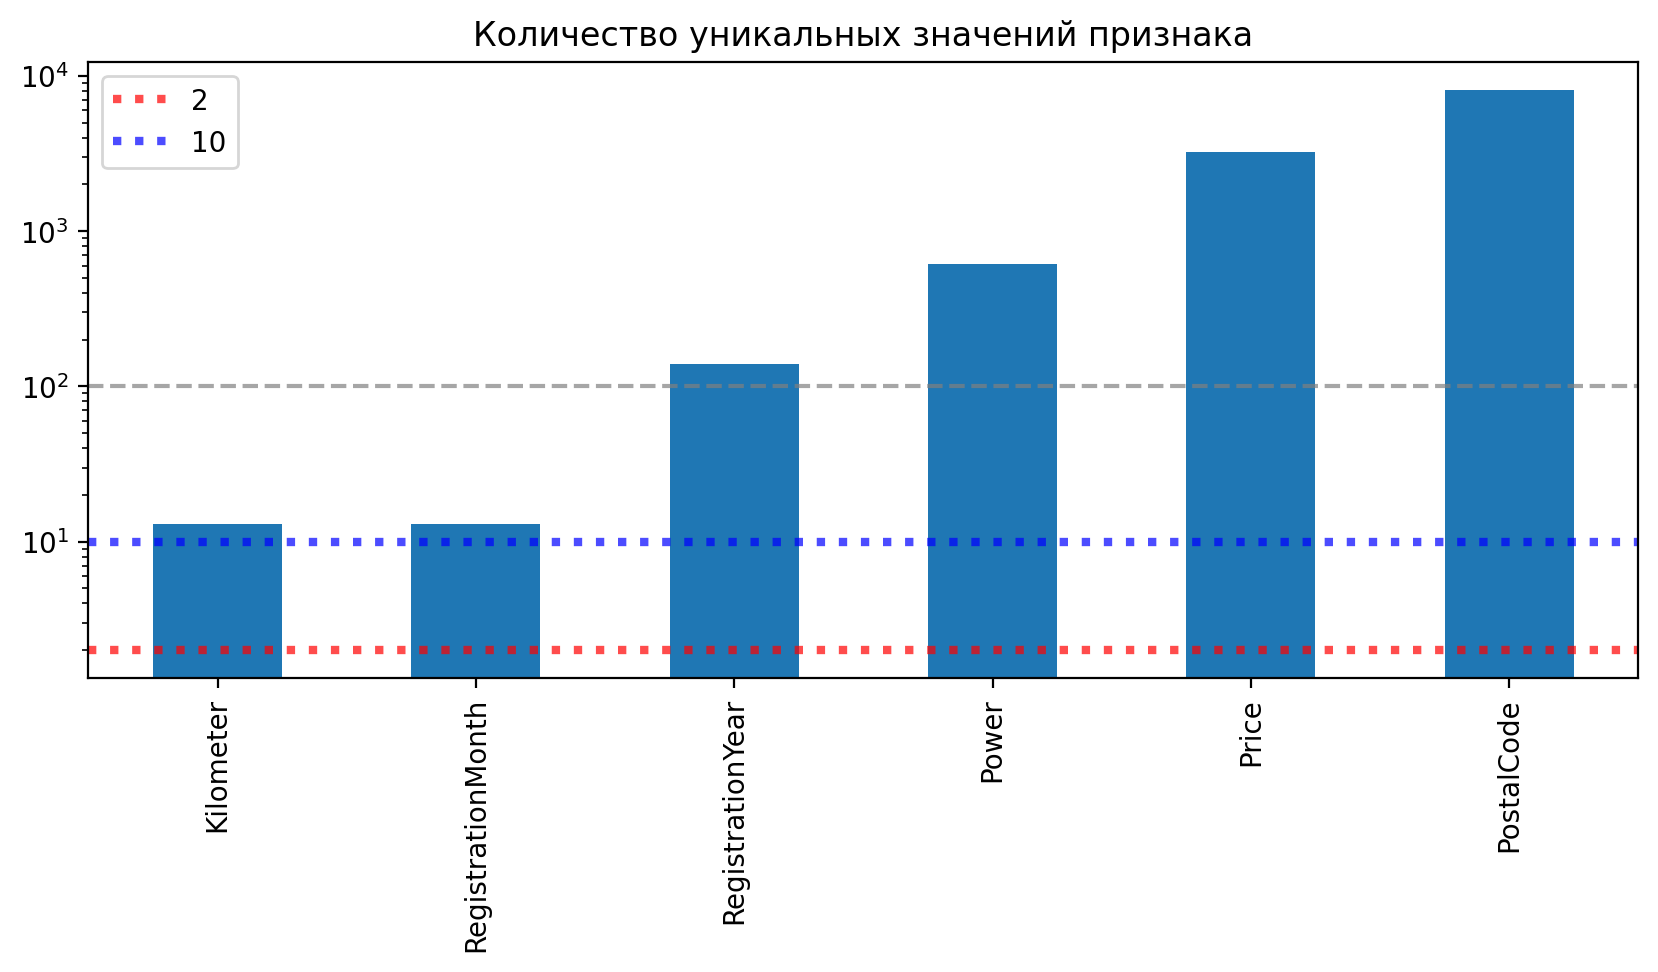

In [25]:
# для каждого числового столбца посчитаем количество уникальных значений и отсортируем
unique_values = df[numerical_columns].nunique().sort_values()

# Построим график с логарифимческой шкалой
unique_values.plot.bar(
    logy = True, figsize = (10, 4),
    title = 'Количество уникальных значений признака'
);

# добивим горизонтальные линии для значений 2 и 10, чтобы визуализировать бинарные и 
# дискретные признаки 
plt.axhline(2, color='red', lw = 3, alpha=0.7, linestyle='dotted')
plt.axhline(10, color='blue', lw = 3, alpha=0.7, linestyle='dotted')

# добавим линию сетки для значения 100
plt.axhline(100, color='gray', alpha=0.7, linestyle='dashed')


plt.legend([2, 10])
plt.show()

Видим, что признак "пробег" чуть больше 10 уникальных значений и является дискретным. 

"Год регистрации" содержит более 100 уникальных значений, что сопоставимо с историей автомобилестроения. Гипотеза, что этот признак содержит некорректные значения, усиливается.

Отметим, что цена представлена примерно 3-мя тысячами уникальных значений для 250 тысяч объектов. 

Наибольшим разнообразием отличаются значения почтовых индексов.

#### Качество данных

На этом этапе оценим общее качество данных в датасете: дубликаты, пропуски, ошибки заполнения.

##### Дубликаты

In [26]:
duplicates_number = df.duplicated().sum()
print(f'Нашли {duplicates_number} дубликатов в датасете.')

Нашли 3324 дубликатов в датасете.


Дубликаты нам не нужны, удалим.

In [27]:
df = df.drop_duplicates().reset_index(drop = True)

##### Пропуски

На этапе обзора структуры данных, мы видели пропуски в категориальных признаках, а также неявные пропуски в численных.

In [28]:
(df[datetime_columns + categorical_columns].isna().sum() /
 df.shape[0]).sort_values(ascending=True)

DateCrawled    0.000000
DateCreated    0.000000
LastSeen       0.000000
Brand          0.000000
Model          0.056020
Gearbox        0.056302
FuelType       0.093583
VehicleType    0.106164
NotRepaired    0.202236
dtype: float64

In [29]:
((df[numerical_columns] == 0).sum() / df.shape[0]).sort_values(ascending=True)

RegistrationYear     0.000000
Kilometer            0.000000
PostalCode           0.000000
Price                0.030449
RegistrationMonth    0.105412
Power                0.113891
dtype: float64

Мы видим пропуски в признаках Model, Gearbox, FuelType, VehicleType, NotRepaired, Price, RegistrationMonth, Power.



In [30]:
(df[df.Price == 0][categorical_columns].isna().sum() /
 df[df.Price == 0].shape[0]).sort_values(ascending=True)

Brand          0.000000
Model          0.203570
Gearbox        0.233360
FuelType       0.318706
VehicleType    0.349436
NotRepaired    0.496243
dtype: float64

In [31]:
nan_columns = ['Price', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'RegistrationMonth', 'Power']

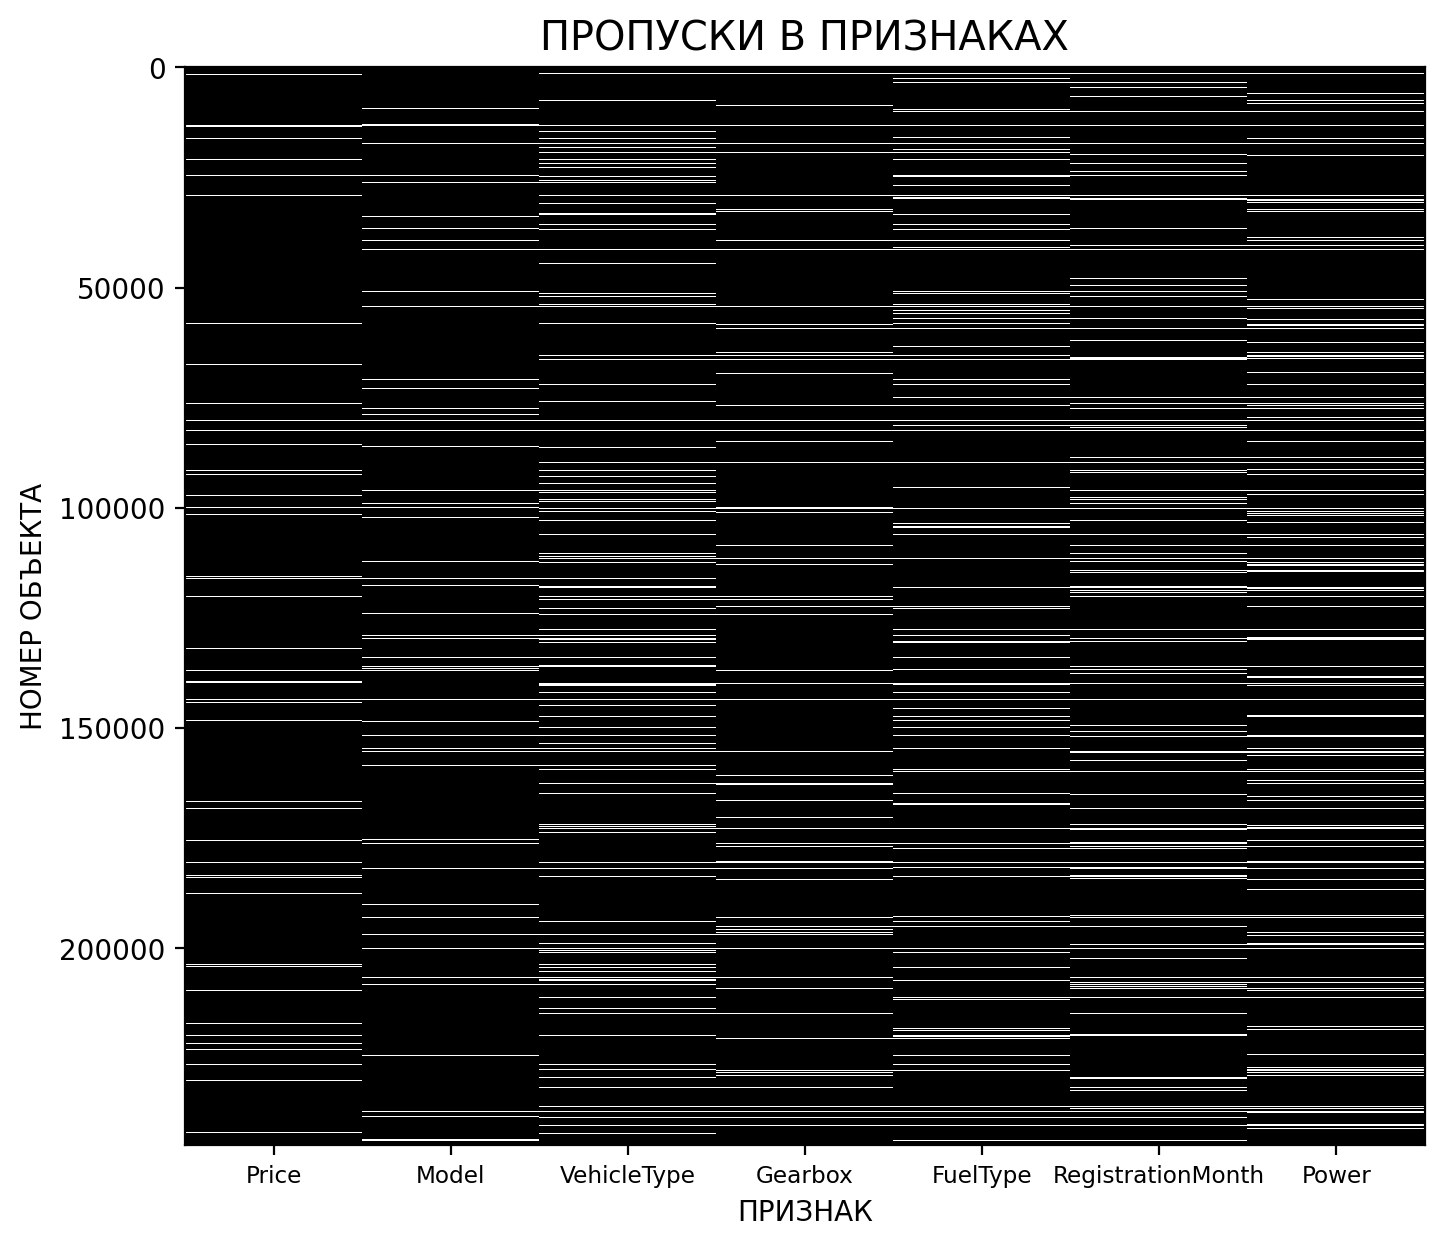

In [32]:
plt.figure(figsize=(8, 7))
plt.imshow((df[nan_columns].isna()) |
           (df[nan_columns] == 0),
           aspect='auto',
           interpolation='nearest',
           cmap='gray')
plt.xlabel('Признак'.upper())
plt.xticks(ticks=range(len(nan_columns)),
           labels=nan_columns,
           fontsize='small')
plt.ylabel('Номер объекта'.upper())
plt.title('Пропуски в признаках'.upper(), fontsize='x-large')
plt.show()

Видим, что пропуски распределены по датасету более-менее равномерно, без явных паттернов.

Есть объекты с пропусками в нескольких признаках -- горизонтальные прямые вдоль нескольких признаков на графике.

В нашем датасете 3% объектов с нулевым значением целевого признака. Примем, что нулевой цена автомобилия быть не может. Заполнение этого значения внесет искажение в обучение. Поэтому удалим эти объекты.

In [33]:
df = df[df.Price > 0]
df.shape

(237282, 16)

##### Ошибки заполнения числовых признаков

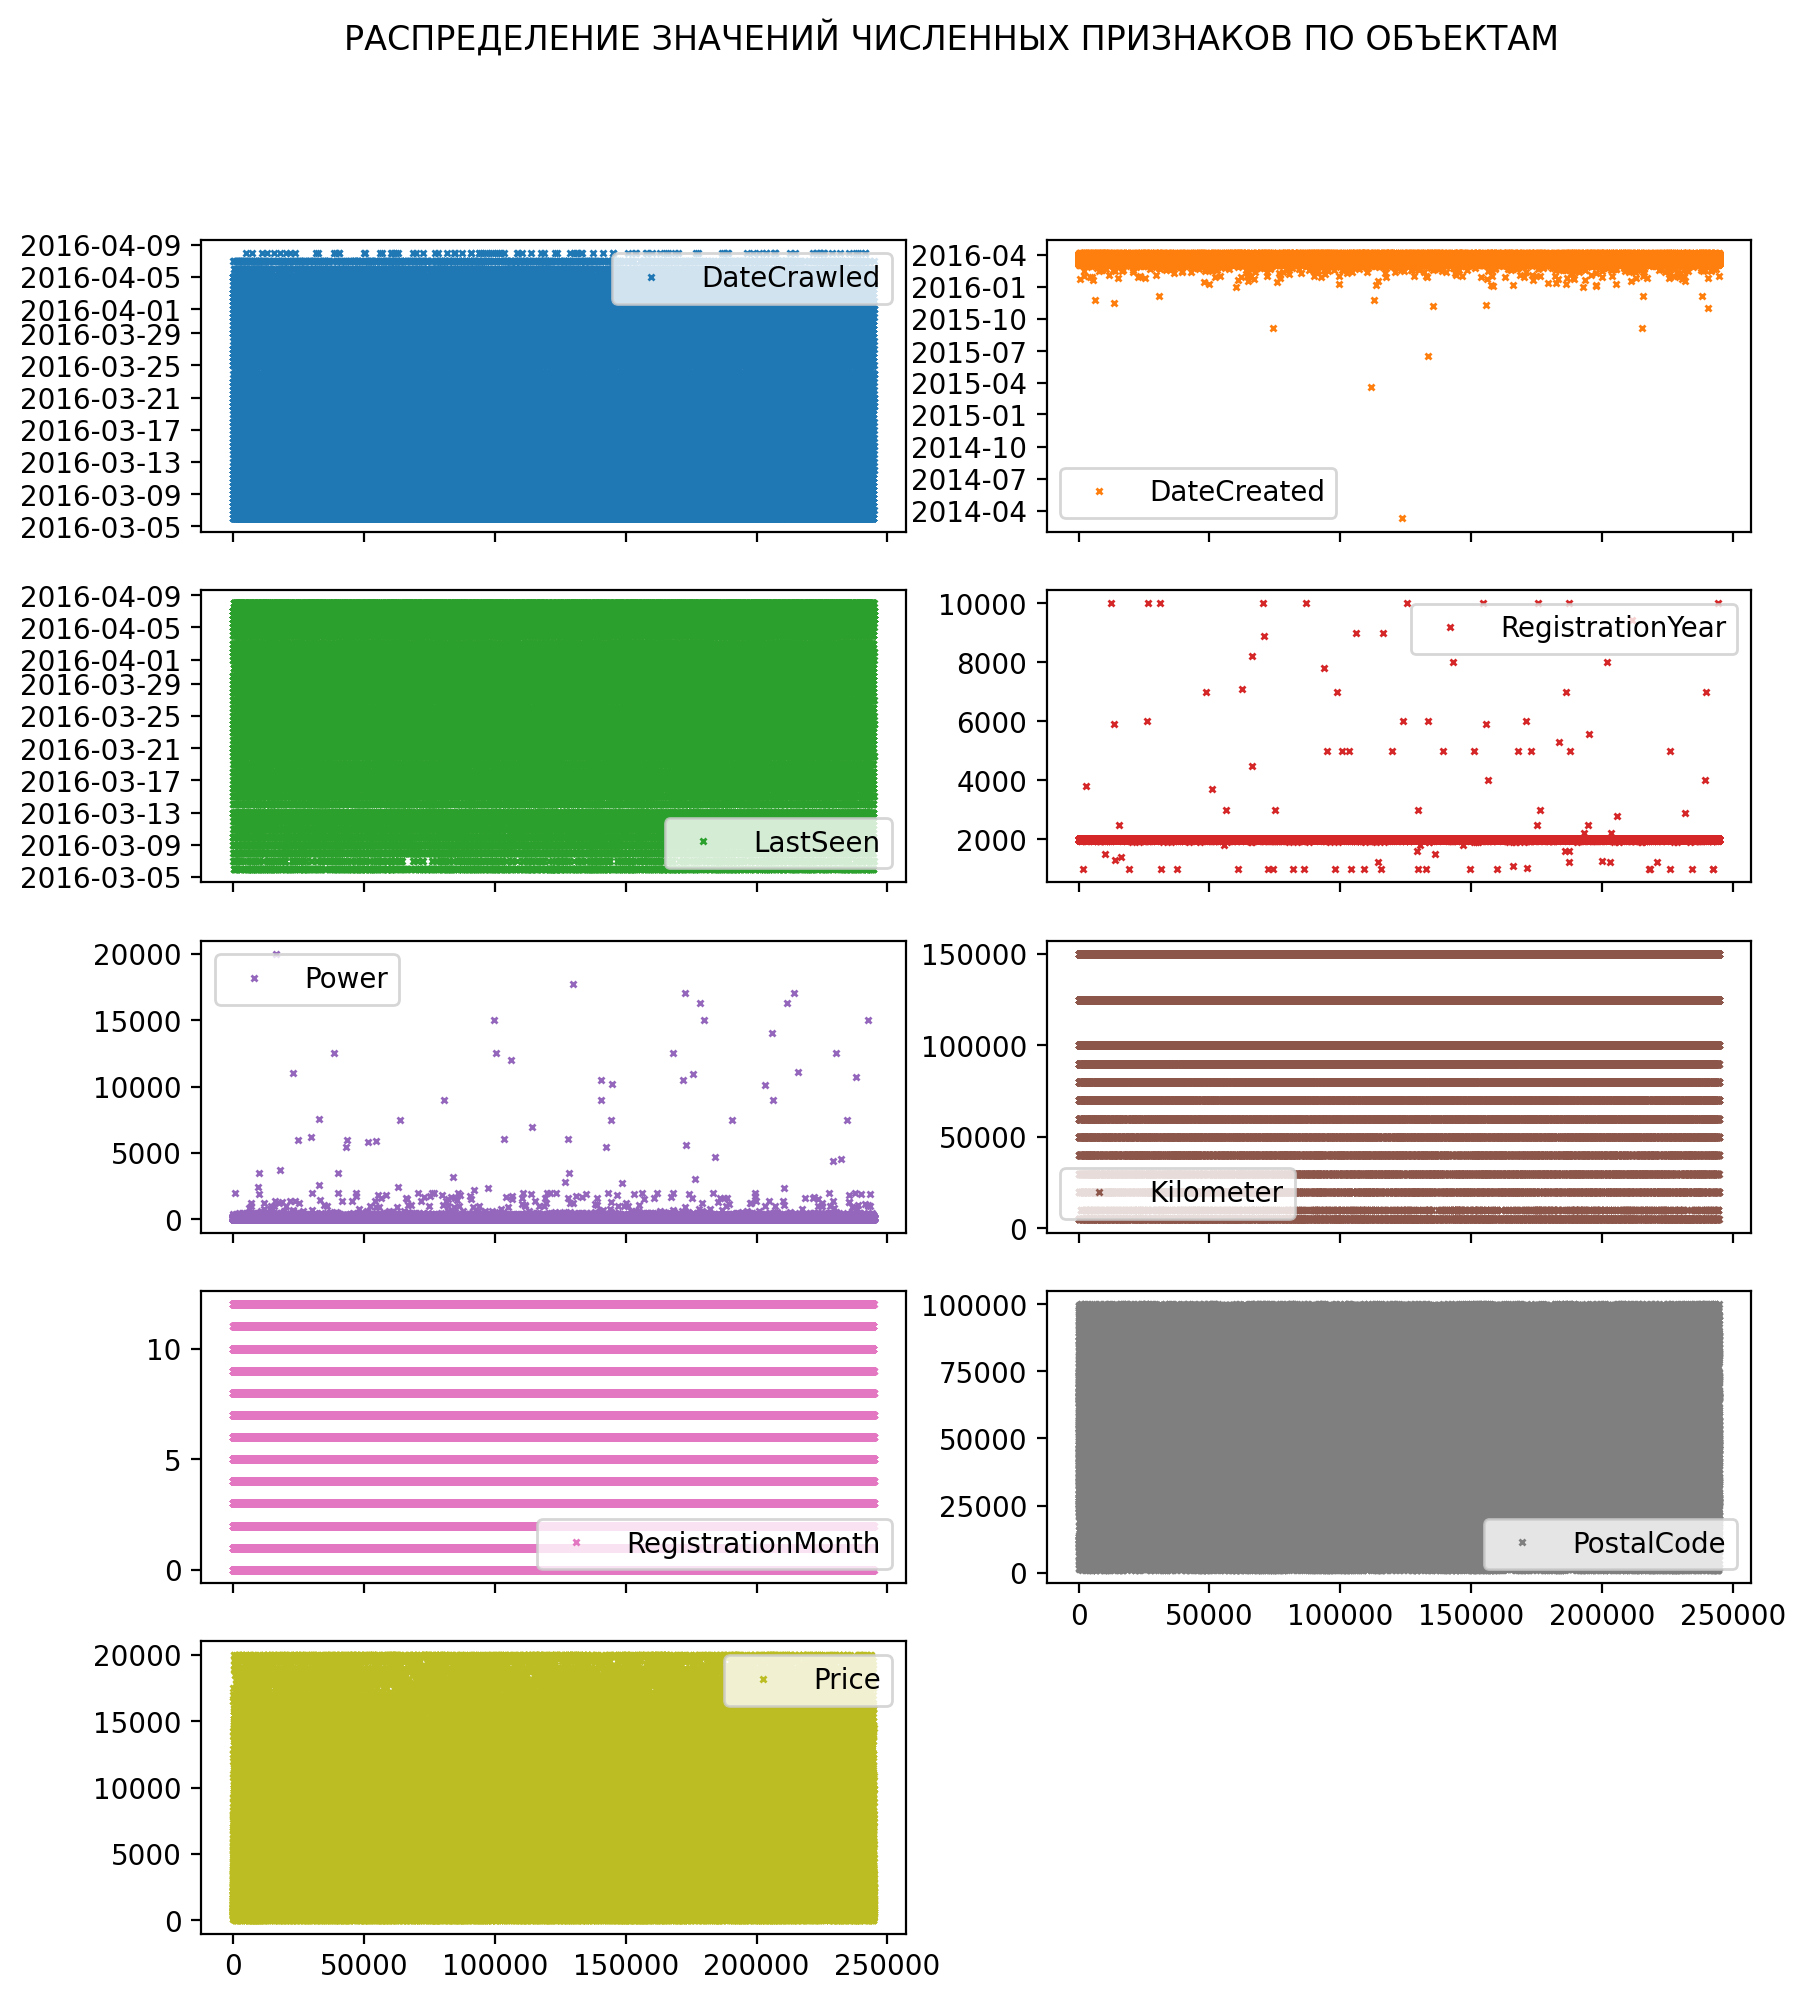

In [34]:
df[datetime_columns + numerical_columns].plot(
    lw=0, marker="x", subplots=True, layout=(-1, 2),
    figsize=(10, 11), markersize=2, 
    title = 'Распределение значений численных признаков по объектам'.upper()
);

plt.show()

##### Ошибки заполнения категориальных признаков

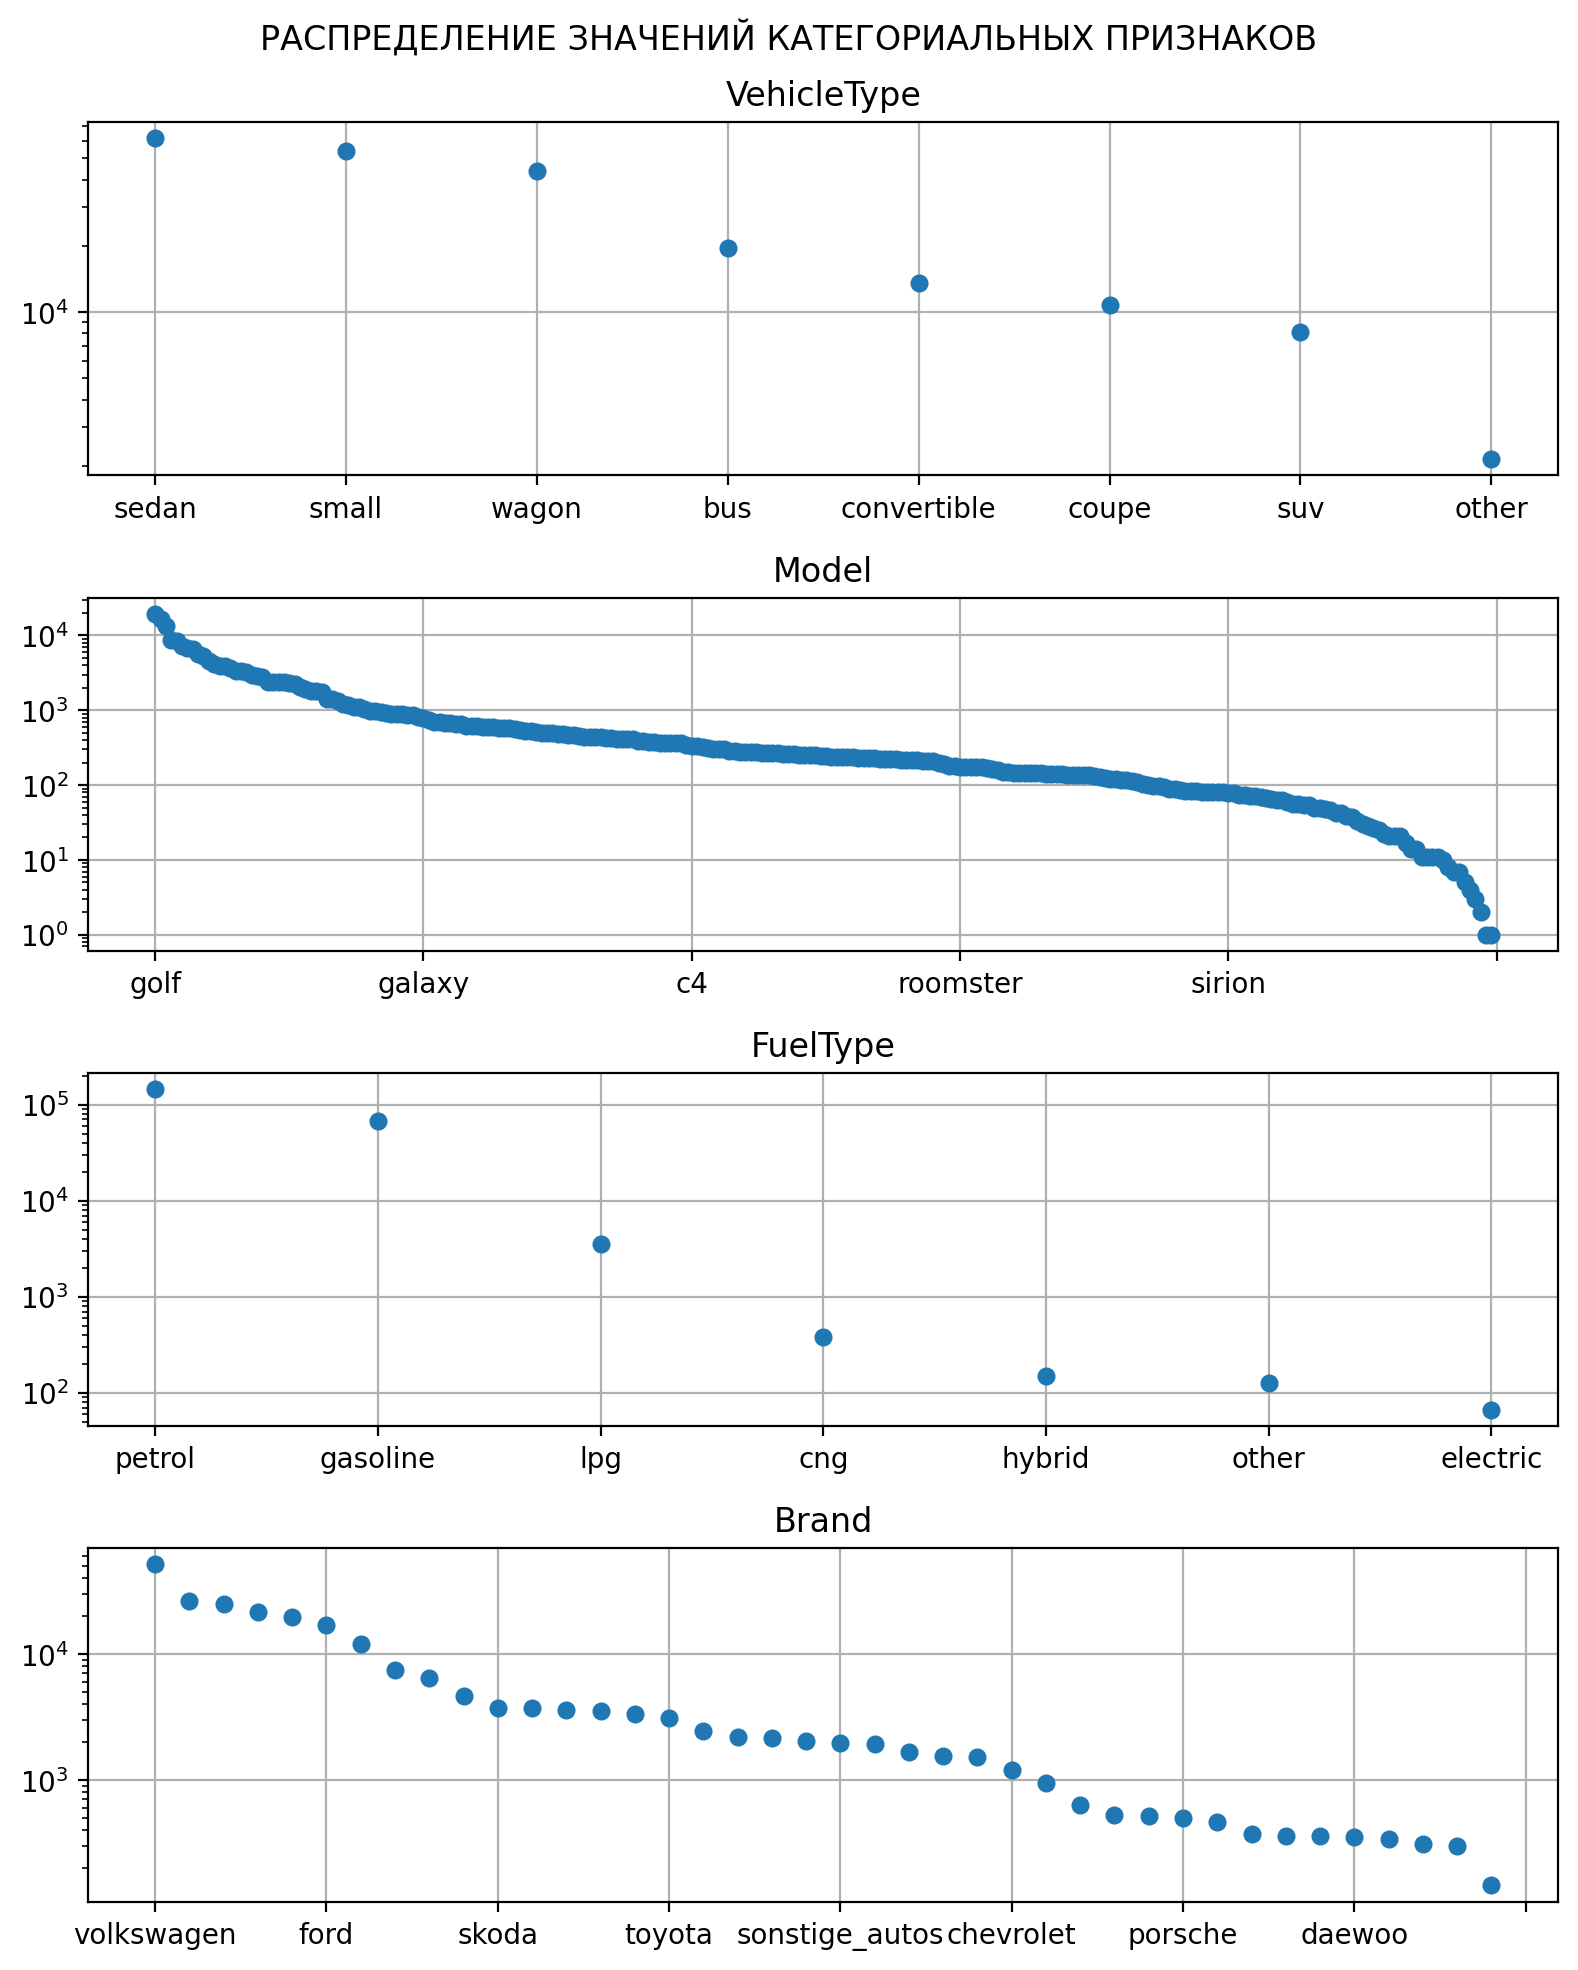

In [35]:
columns = [_ for _ in categorical_columns if _ not in ['Gearbox', 'NotRepaired']]

# Создадим фигуру с количеством графиков, равных количеству столбцов
fig, axes = plt.subplots(ncols=1,
                         nrows=len(columns),
                         figsize=(8, 10))

# Добавим в цикле график для каждого признака на соответсвующей оси
for col, ax in zip(columns, axes.ravel()):

    # Посчитаем количество уникальных значений признака
    df[col].value_counts().plot(

        # Отобразим на графике в логарифмической шкале
        logy=True,
        title=col,
        lw=0,
        marker='.',
        ax=ax,
        markersize=11,
        grid=True)

plt.suptitle('Распределение значений категориальных признаков'.upper())
plt.tight_layout()
plt.show()

Liquefied petroleum gas (LPG) – also known as autogas – is a widely used alternative fuel. LPG is a mixture of propane and butane, and it is being produced as by-product of natural gas and oil refining industry.

Compressed natural gas (CNG) is a fuel gas mainly composed of methane (CH4), compressed to less than 1% of the volume it occupies at standard atmospheric pressure.

[In the US and Latin countries, term gasoline is used, but in Europe and Asian countries it's called petrol](https://en.wikipedia.org/wiki/Gasoline).

#### Анализ значений

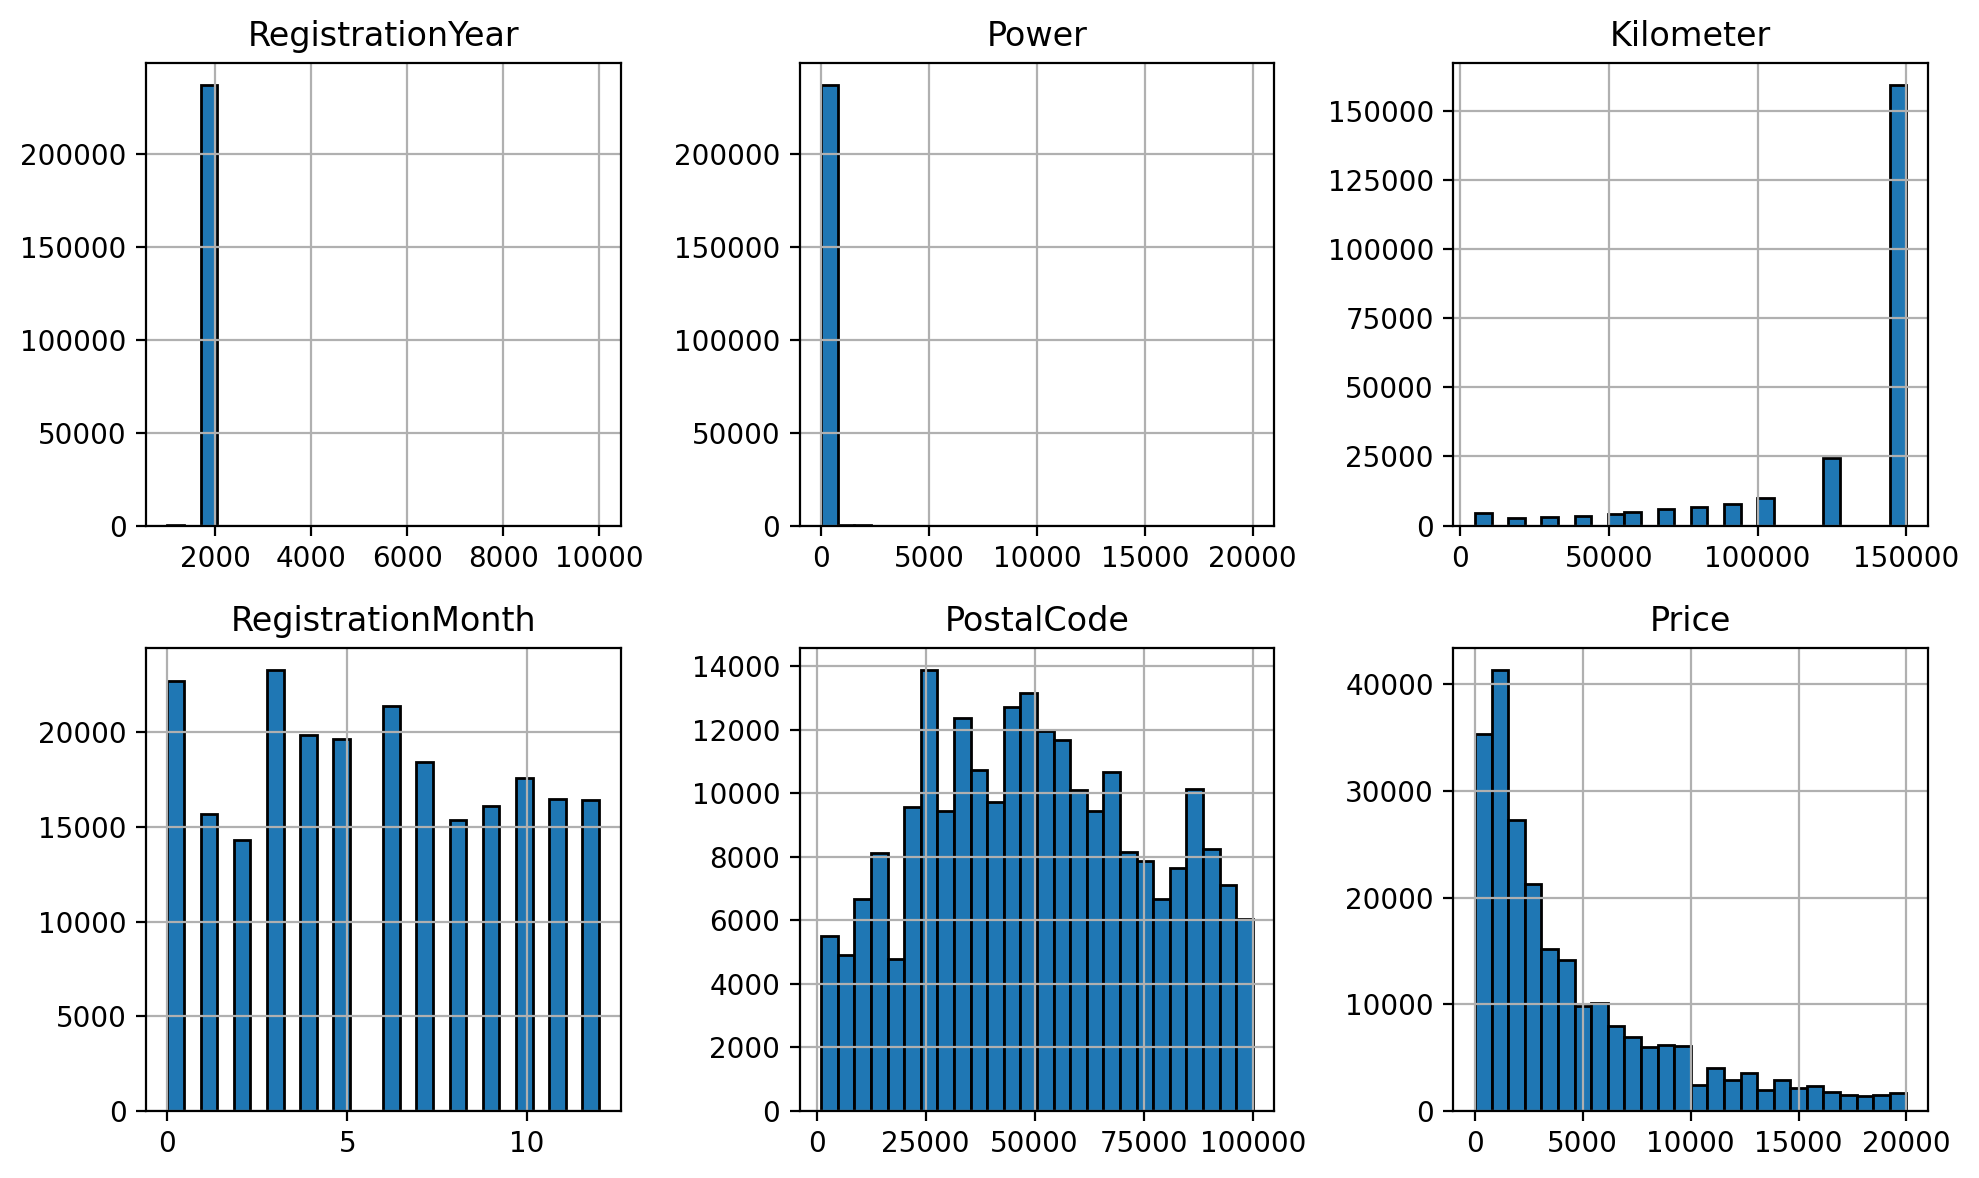

In [36]:
df[numerical_columns].hist(bins=26,
                           figsize=(10, 6),
                           layout=(-1, 3),
                           edgecolor="black")
plt.tight_layout()
plt.show()

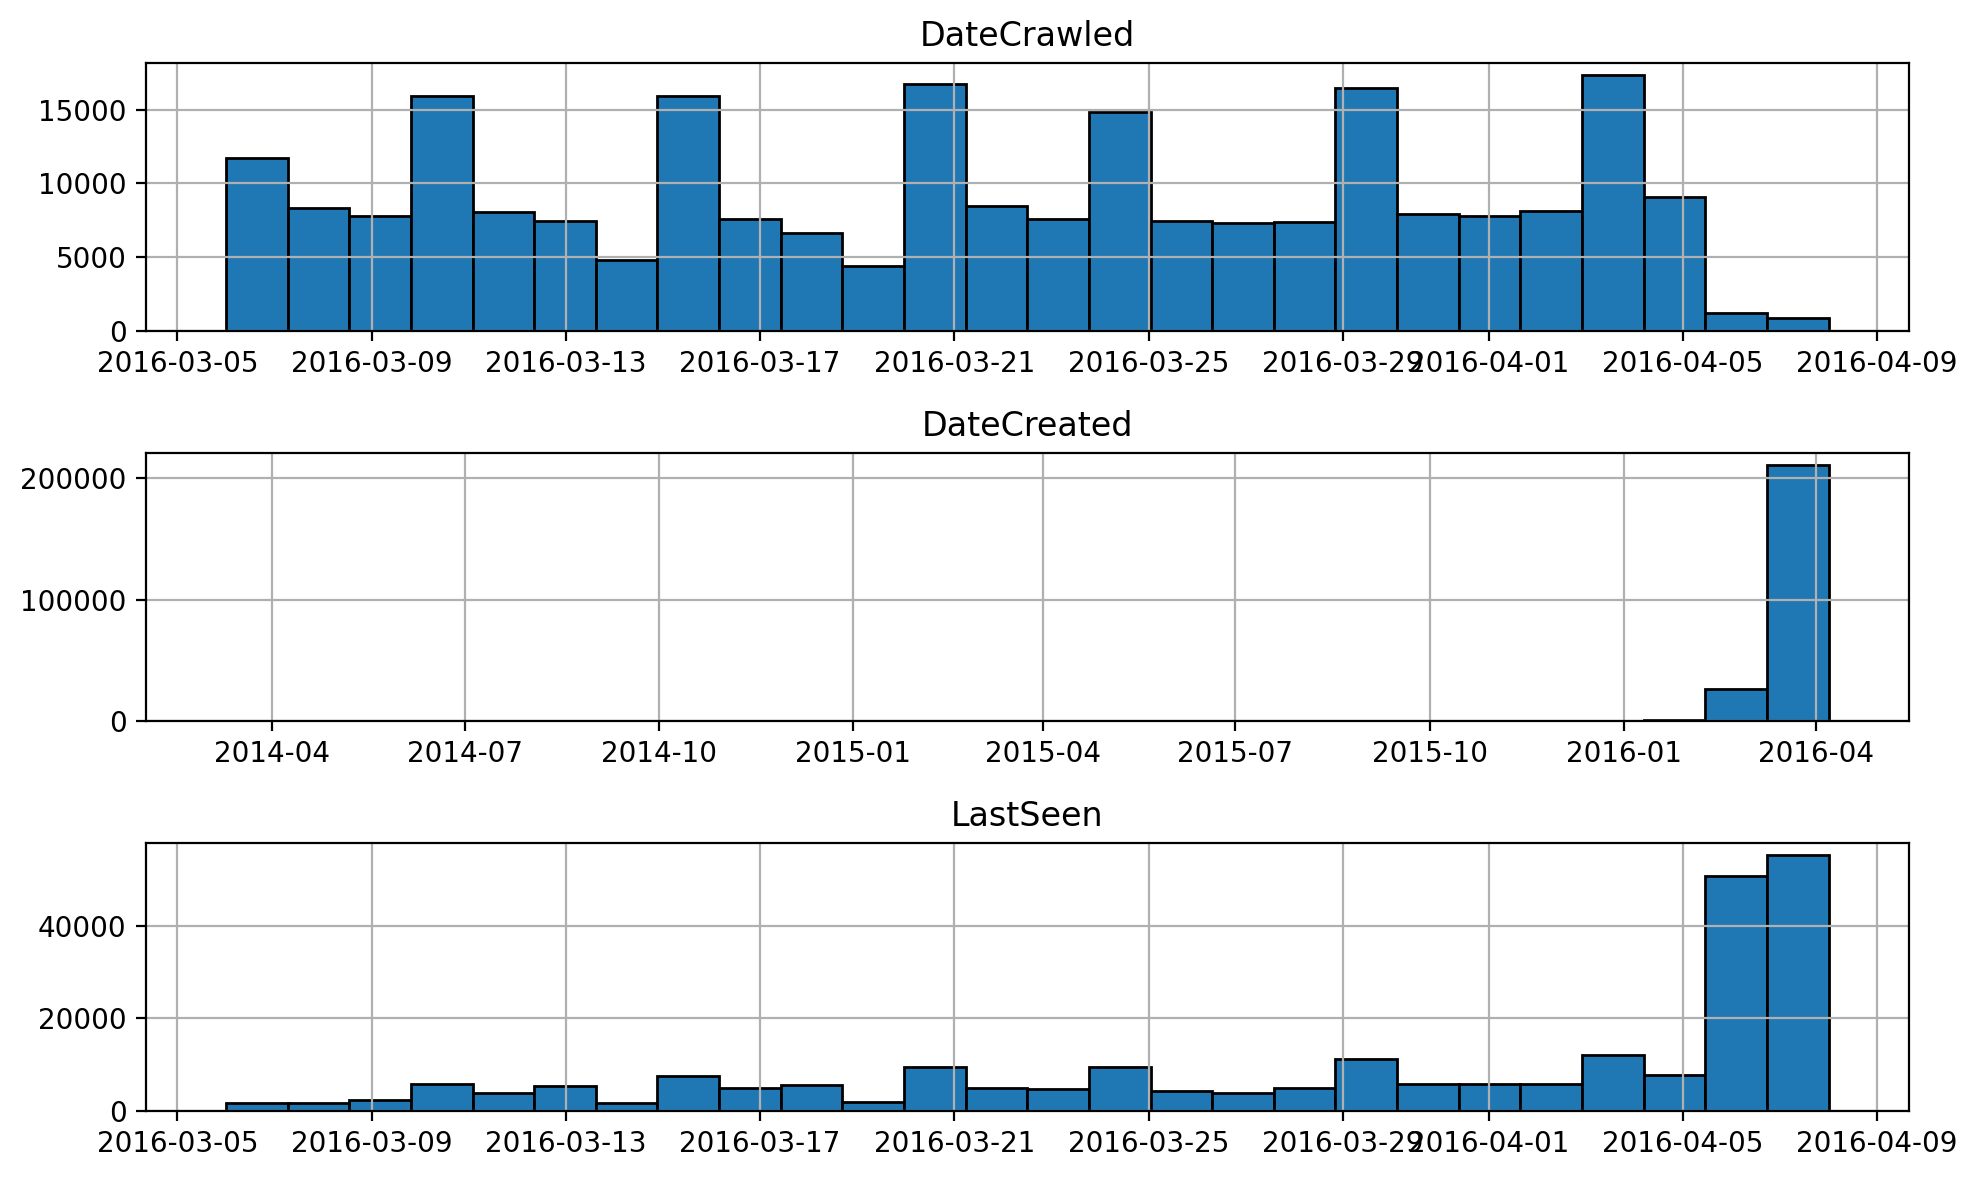

In [37]:
df[datetime_columns].hist(bins=26,
                           figsize=(10, 6),
                           layout=(-1, 1),
                           edgecolor="black")
plt.tight_layout()
plt.show()

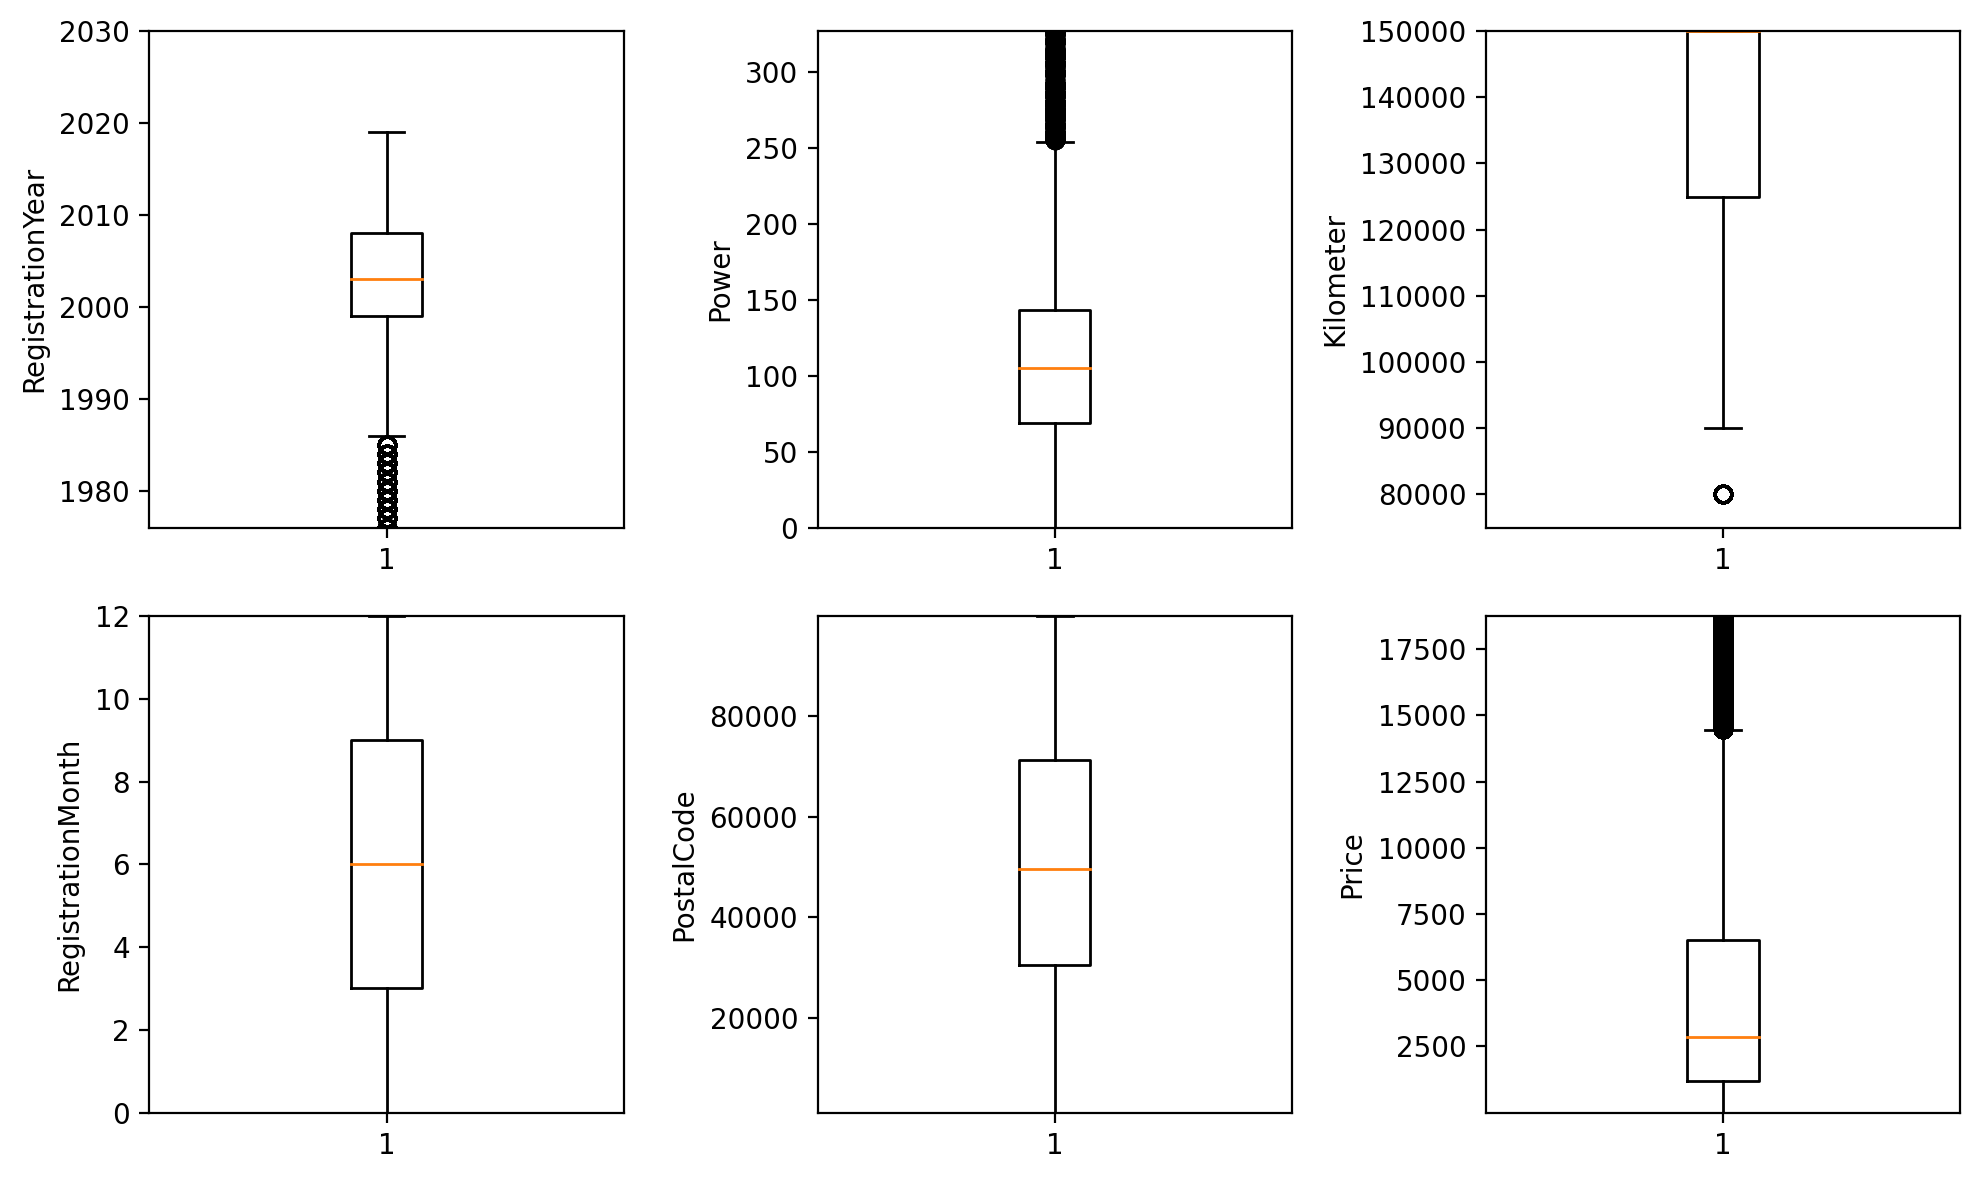

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

def draw_boxplot(ax, x, column_name, ylabel):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    median = x.median()
    data_range = (
        max(x.min(), median-3*iqr),
        min(x.max(), median+3*iqr)
    )
    ax.boxplot(x=x)
    ax.set_ylim(data_range)
    ax.set(ylabel=column)
    
for column, ax in zip(numerical_columns, axes.ravel()):
    draw_boxplot(ax, df[column], column, 'label')
plt.tight_layout()
plt.show()

Мощность двигателей спорт-каров до 1700лс, топовые коммерческие авто до 500лс. [Источник hotcars.com](https://www.hotcars.com/most-powerful-engines-ever-fitted-production-cars/)

In [87]:
df['age'] = 2016 - df.RegistrationYear

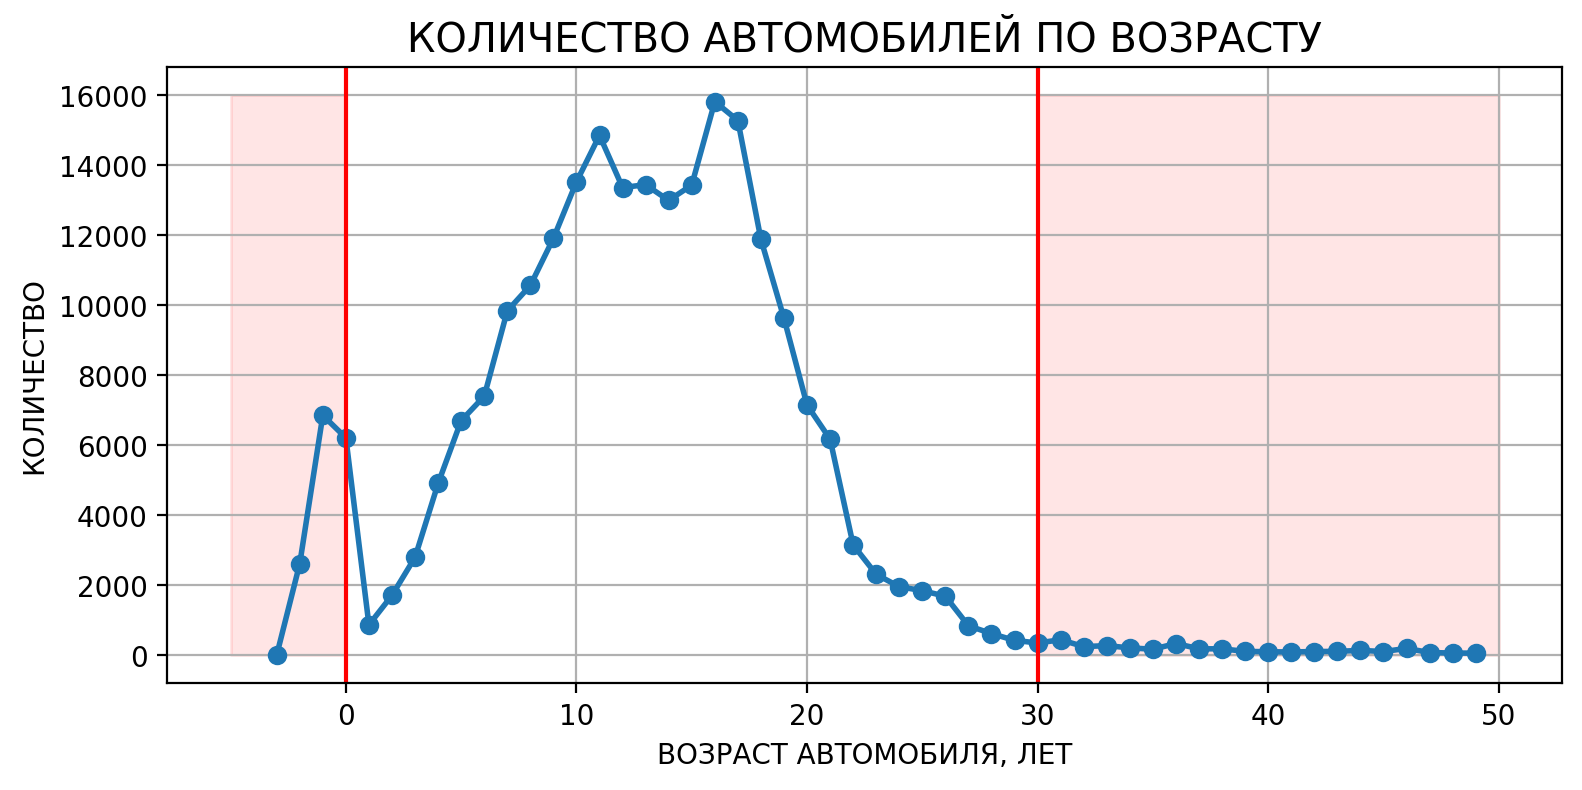

In [131]:
df.loc[(df.age > -5) & (df.age < 50),
       ['age', 'Price']].groupby(['age'
                                               ]).count().plot(lw=2,
                                                               marker='o',
                                                               figsize=(9, 4),
                                                               grid=True,
                                                               legend=None)
plt.axvline(0, c='r')
plt.axvline(30, c='r')
plt.fill_between([-5,0], 16000, color='r', alpha=.1)
plt.fill_between([30,50], 16000, color='r', alpha=.1)
plt.title('Количество автомобилей по возрасту'.upper(),
          fontsize='x-large')
plt.ylabel('Количество'.upper())
plt.xlabel('Возраст автомобиля, лет'.upper())
plt.show()

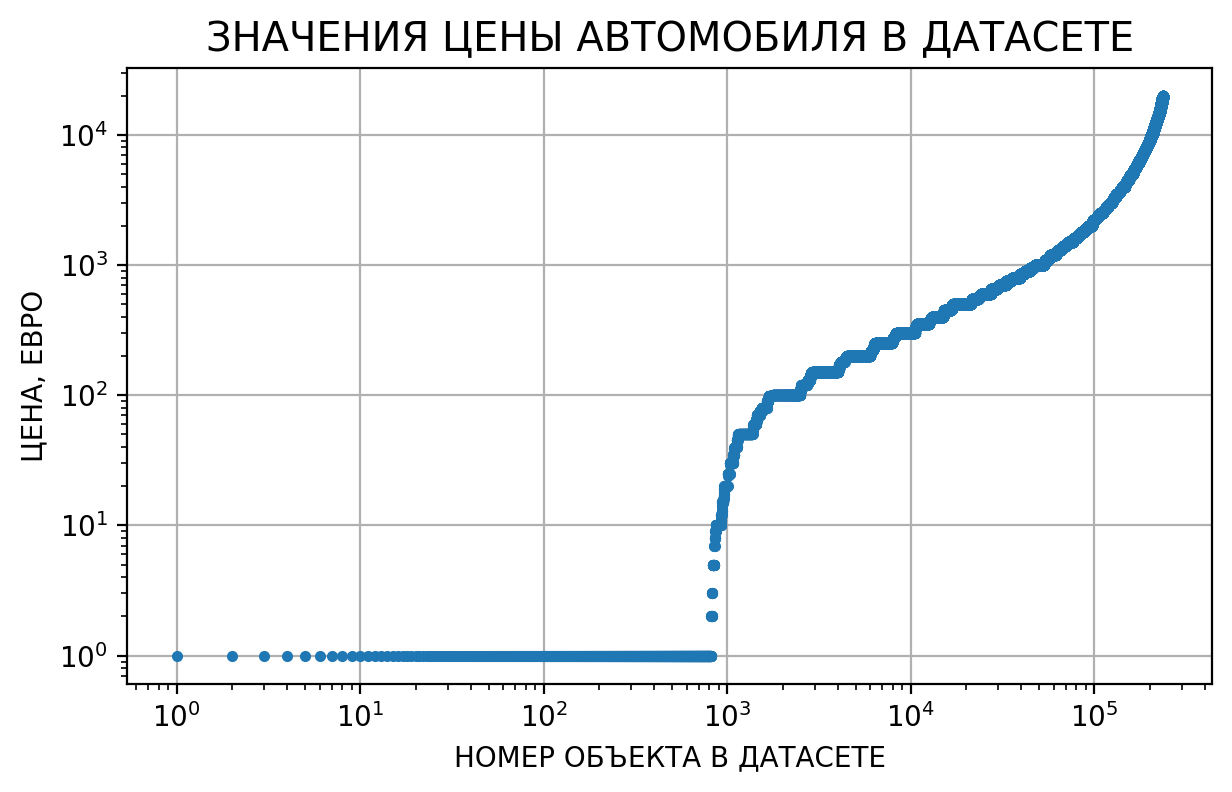

In [109]:
fig = plt.figure(figsize=(7, 4))
plt.plot(range(df.shape[0]),
         df.Price.sort_values(),
         marker='o',
         lw=0,
         ms=3)
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.title('Значения цены автомобиля в датасете'.upper(), fontsize='x-large')
plt.ylabel('Цена, евро'.upper())
plt.xlabel('Номер объекта в датасете'.upper())
plt.show()

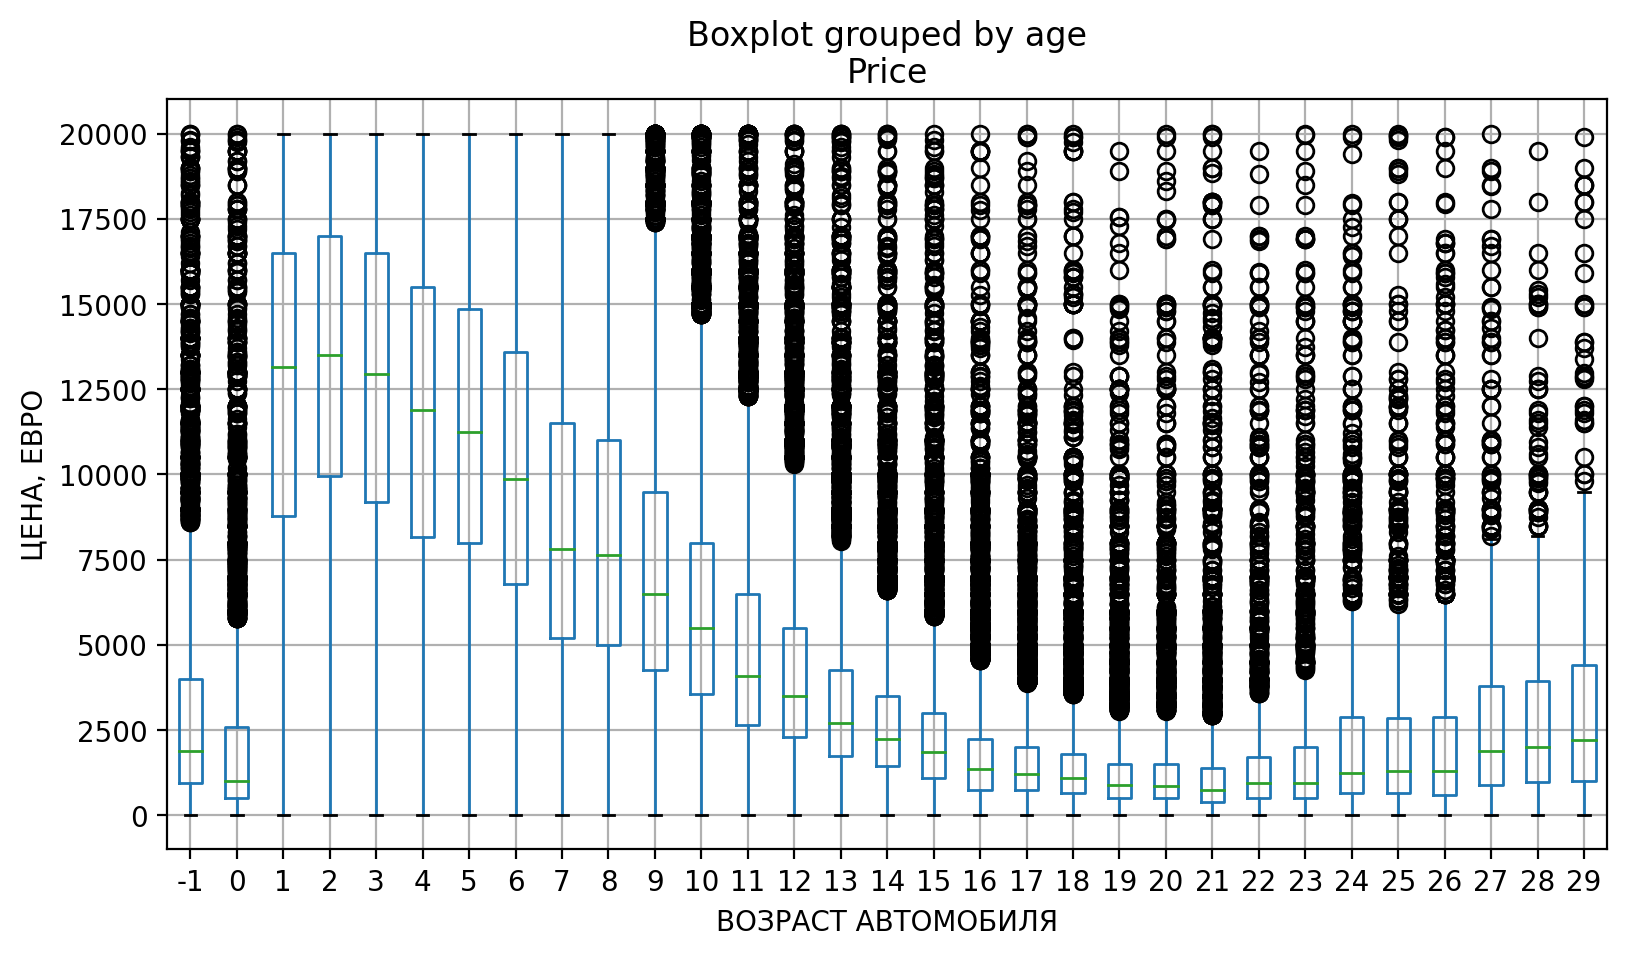

In [130]:
df.loc[(df.age > -2) & (df.age < 30), ['age', 'Price']].boxplot(column='Price',
                                                                by='age',
                                                                figsize=(9, 5))
plt.xlabel('Возраст автомобиля'.upper())
plt.ylabel('Цена, евро'.upper())
plt.show()

In [41]:
df.Model.unique()

array(['stilo', 'golf', 'polo', 'a3', 'octavia', 'corsa', 'sprinter',
       'fiesta', 'punto', 'ka', 'other', 'transporter', '1er', 'twingo',
       'passat', '3er', 'forester', '6_reihe', 'c_klasse', 'a_klasse',
       'mondeo', 'tt', 'vito', nan, 'touareg', 'legacy', 'a4', 'i_reihe',
       'sharan', 'voyager', 'espace', 'fox', '80', '3_reihe', 'fusion',
       'clk', 'omega', 'astra', 'megane', 'ibiza', '7er', 'alhambra',
       'vectra', 'scenic', 'civic', 'materia', '5er', 'z_reihe',
       '2_reihe', 'laguna', 'clio', 'corolla', 'cr_reihe', 'zafira',
       'cooper', 'mx_reihe', 'kangoo', 'almera', 'picanto', 'focus',
       's_type', 'v50', 'bravo', 'aygo', 'x_reihe', 'a6', 'colt',
       's_klasse', 'jetta', 'avensis', 'fortwo', 'lanos', 'grand', 'lupo',
       'b_klasse', 'eos', 'sportage', 'jimny', 'e_klasse', 'meriva',
       'kaefer', 'yaris', '1_reihe', 'sl', 'tiguan', 'a2', 'fabia',
       'm_klasse', 'boxster', 'bora', 'a5', 'c4', '147', 'micra',
       'escort', 'phaet

In [132]:
df.Brand.unique()

array(['fiat', 'volkswagen', 'audi', 'skoda', 'opel', 'mercedes_benz',
       'ford', 'bmw', 'renault', 'subaru', 'mazda', 'hyundai', 'chrysler',
       'peugeot', 'suzuki', 'seat', 'honda', 'daihatsu', 'toyota', 'mini',
       'nissan', 'kia', 'jaguar', 'volvo', 'mitsubishi', 'alfa_romeo',
       'smart', 'daewoo', 'jeep', 'chevrolet', 'porsche', 'citroen',
       'sonstige_autos', 'land_rover', 'saab', 'rover', 'dacia', 'lancia',
       'lada', 'trabant'], dtype=object)

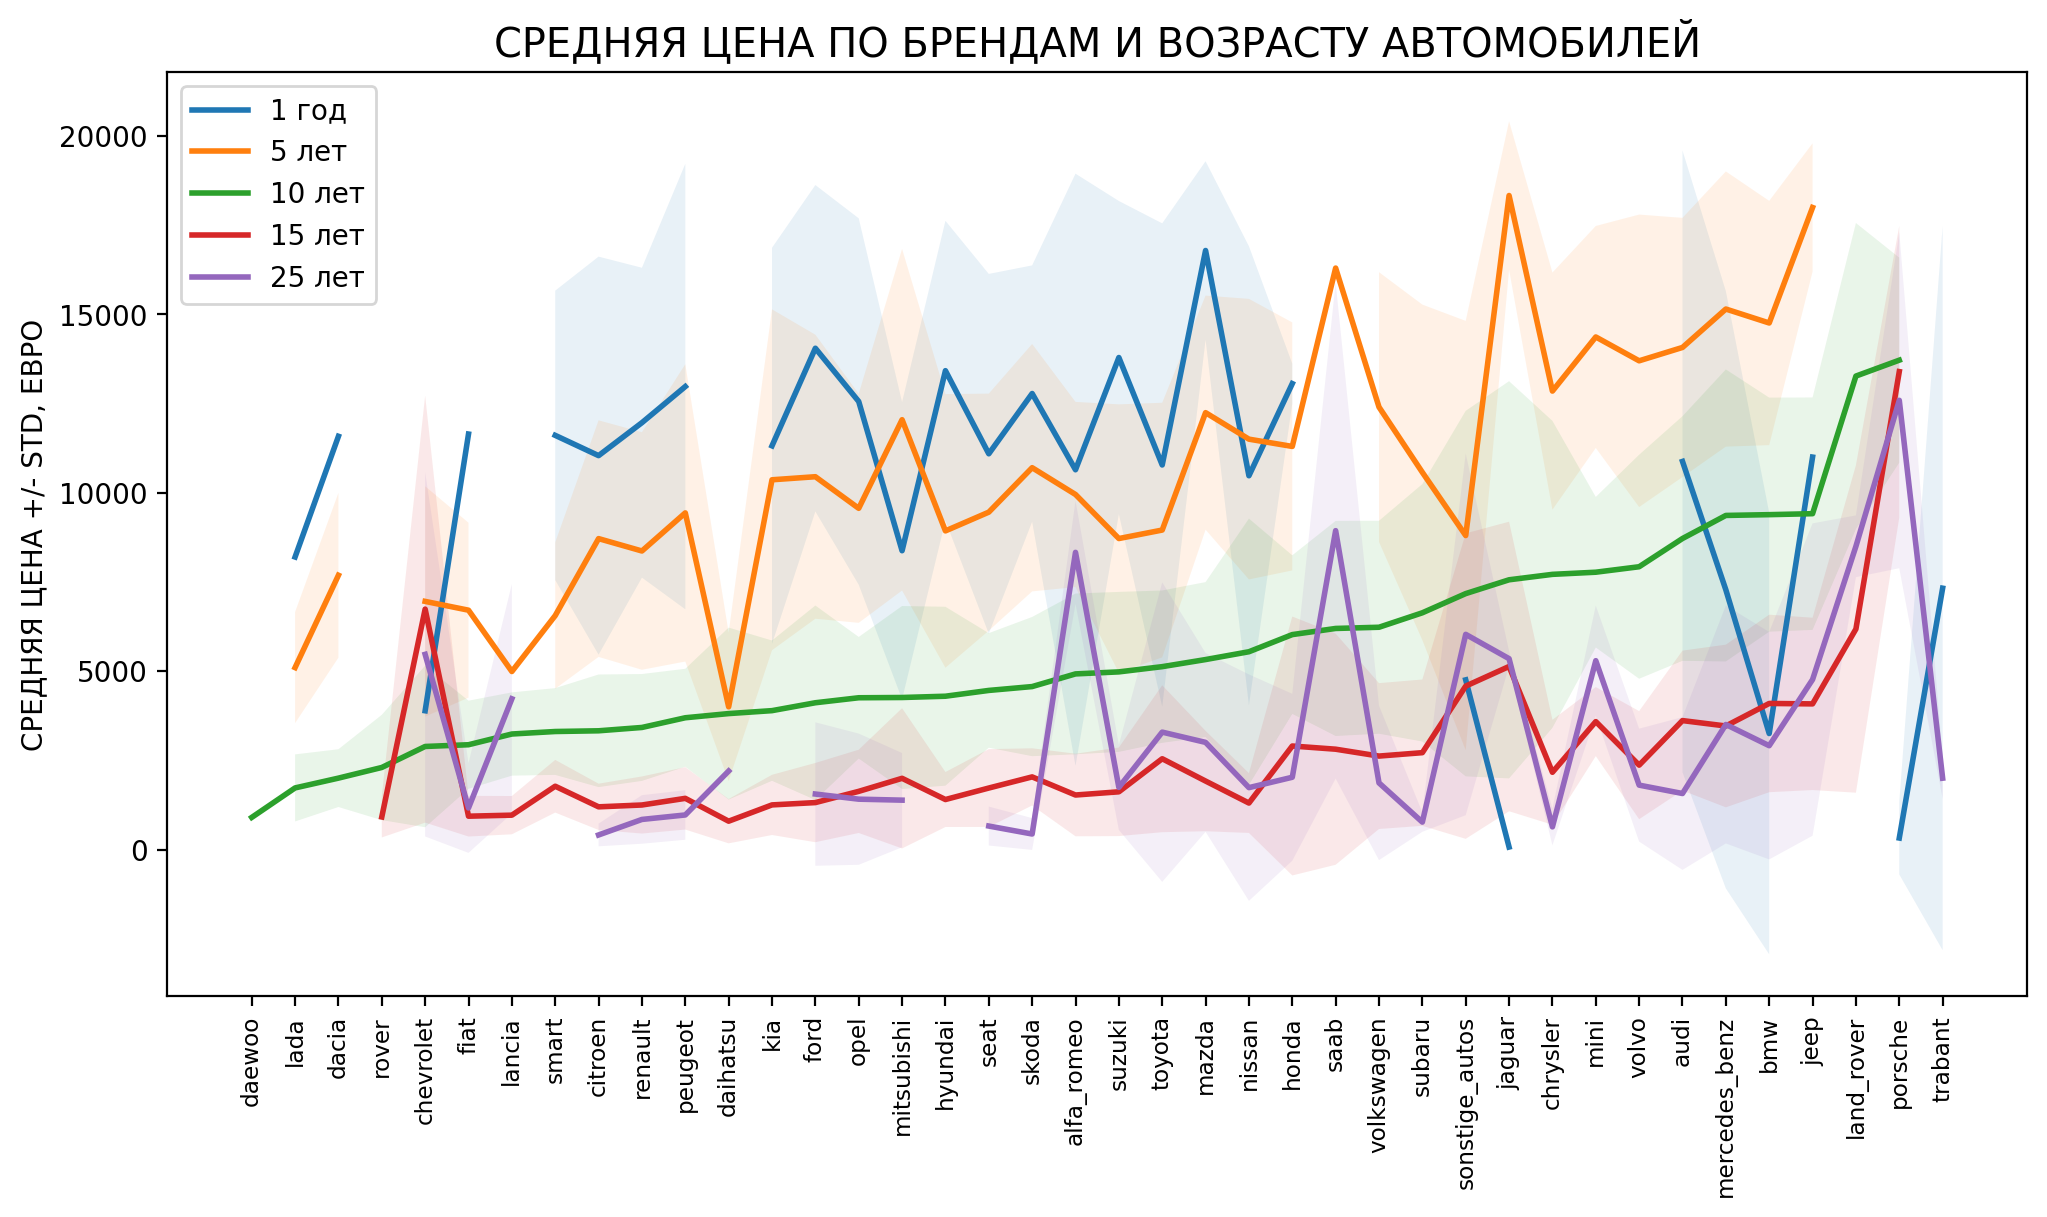

In [214]:
ages = [1, 5, 10, 15, 25]
prices = df.loc[df.age.isin(ages),
                ['age', 'Brand', 'Price']].pivot_table(
                    index='Brand',
                    values='Price',
                    columns='age',
                    aggfunc=['mean', 'std']).sort_values(by=('mean', 10))
fig = plt.figure(figsize=(12, 6))
for age in ages:
    plt.plot(prices.index,
             prices[('mean', age)],
             lw=2,
             label=f"{age} {'год' if age == 1 else 'лет'}")
    plt.fill_between(prices.index,
                     prices[('mean', age)] - prices[('std', age)],
                     prices[('mean', age)] + prices[('std', age)],
                     alpha=.1)
    plt.legend(loc='upper left')
    plt.xticks(rotation=90, fontsize='small')
    plt.title('Средняя цена по брендам и возрасту автомобилей'.upper(),
              fontsize='x-large')
    plt.ylabel('Средняя цена +/- std, евро'.upper())
plt.show()

### Выводы

## Обучение моделей

## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей